# Difftest Results

Connect to results database:

In [124]:
import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [125]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLSmith w. cldrive", "GitHub", "CLgen", "CLgen w. cl_launcher", "CLgen w. co"]
TABLES = [CLSmithResult, cldriveCLSmithResult, GitHubResult, CLgenResult, cl_launcherCLgenResult, coCLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES]),
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLSmith w. cldrive,GitHub,CLgen,CLgen w. cl_launcher,CLgen w. co
#. Programs,10001,10001,9238,3385,2385,3385
#. Testbeds,6,5,5,5,6,6
#. Params,4,4,4,4,4,4
#. Results,201057,200020,193477,60173,57240,40874


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

In [126]:
import sqlalchemy as sql

q = session.query(Testbed).order_by(sql.func.field(Testbed.devtype, 'GPU', 'CPU', 'Emulator'))

data = []
for testbed in q:
    data.append(
        (testbed.id, [
            host_str(testbed.host), DEVICES.get(testbed.device, testbed.device),
            DRIVERS.get(testbed.driver, testbed.driver), testbed.opencl, testbed.devtype] +
         [session.query(t.testbed).filter(t.testbed == testbed).count() for t in TABLES]))
i, d = zip(*data)
testbeds = pd.DataFrame(list(d), index=i, columns=["Operating System", "Device", "Driver", "OpenCL", "Device type"] + [f"#. {t}" for t in TABLE_NAMES])
testbeds

,Operating System,Device,Driver,OpenCL,Device type,#. CLSmith,#. CLSmith w. cldrive,#. GitHub,#. CLgen,#. CLgen w. cl_launcher,#. CLgen w. co
12,Ubuntu 16.04 64bit,Intel E5-2620 (pocl),0.14,2.0,3,280028,280028,258664,94780,66780,55216
3,Ubuntu 16.04 64bit,NVIDIA GTX 1080,375.39,1.2,GPU,280028,280028,332129,94780,66780,53641
13,Ubuntu 16.04 64bit,Intel HD Haswell GT2,1.3,1.2,GPU,7259,0,0,0,66780,0
9,Ubuntu 16.04 64bit,Intel E5-2620 v4,1.2.0.25,2.0,CPU,280028,280028,258664,94780,66780,83503
10,Ubuntu 16.04 64bit,Intel i5-4570,1.2.0.25,1.2,CPU,280028,280028,246218,42091,66780,18060
14,CentOS 7.1 64bit,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,1.2.0.44,1.2,CPU,0,0,0,0,0,1442
11,Ubuntu 16.04 64bit,Oclgrind Simulator,16.10,1.2,Emulator,280028,280028,258664,94780,66780,74256


In [127]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict

def get_testbed_info(testbed_id):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["Platform"] = platform_str(testbed.platform)
    d["Device"] = testbed.device
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = testbed.host
    d["Device type"] = devtype_str(testbed.devtype)
    return d

table = pd.DataFrame([get_testbed_info(x[1]) for x in CONFIGURATIONS],
                     index=[x[0] for x in CONFIGURATIONS])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Platform,Device,Driver,OpenCL,Operating system,Device type
1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU
2,Intel Gen OCL Driver,Intel(R) HD Graphics Haswell GT2 Desktop,1.3,1.2,Ubuntu 16.04 64bit,GPU
3,Intel OpenCL,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU
4,Intel OpenCL,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,1.2.0.44,1.2,CentOS Linux 7.1.1503 64bit,CPU
5,Intel OpenCL,Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU
6,POCL,pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,0.14,2.0,Ubuntu 16.04 64bit,CPU
7,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator


In [128]:
null_columns = " & ".join(["-"] * 6)

def get_clsmith_columns(testbed: Testbed, no_opt: bool):
    # could not run on OCLgrind
    if platform_str(testbed.platform) == "Oclgrind":
        return null_columns
    
    return " & ".join([str(0)] * 6)


def get_clgen_columns(testbed: Testbed, no_opt: bool):
    return " & ".join([str(0)] * 6)
        

def get_row(config_id, testbed_id):
    """ get mega-table row """
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    platform_name = platform_str(testbed.platform)
    device_name = device_str(testbed.device)
    driver_name = driver_str(testbed.driver)
    
    clsmith_columns = get_clsmith_columns(testbed, True)
    clgen_columns = get_clgen_columns(testbed, True)
    
    clsmith_noopt_columns = get_clsmith_columns(testbed, False)
    clgen_noopt_columns = get_clgen_columns(testbed, False)
    
    return f"""\\multirow{{ 2}}{{*}}{{{config_id}}} & \\multirow{{ 2}}{{*}}{{{platform_name}}} & \
\\multirow{{ 2}}{{*}}{{{device_name}}} & \
\\multirow{{ 2}}{{*}}{{{driver_name}}} & \
$-$ & {clsmith_columns} & {clgen_columns} \\\\
& & & & \
$+$ & {clsmith_noopt_columns} & {clgen_noopt_columns} \\\\"""

rows = "\n\\hline\n".join(get_row(*x) for x in CONFIGURATIONS)


# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

latex = f"""\
\\begin{{tabular}}{{lllll | rrrrrr | rrrrrr }}
  \\toprule
  & & & & & \\multicolumn{{6}}{{c|}}{{\\textbf{{CLSmith}}}} & \\multicolumn{{6}}{{c}}{{\\textbf{{CLgen}}}} \\\\
  \\textbf{{\\#.}} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & $\\pm$ & \\textbf{{w}} & \\textbf{{bf}} & \\textbf{{c}} & \\textbf{{to}} & \\cmark & \\xmark & \\textbf{{w}} & \\textbf{{bf}} & \\textbf{{c}} & \\textbf{{to}} & \\cmark & \\xmark \\\\
  \\midrule
  {rows}
  \\bottomrule
\\end{{tabular}}
"""

with open(os.path.expanduser("~/docs/paper-project_b/build/tab/megatable.tex"), "w") as outfile:
    print(latex, file=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/megatable.tex" && git push

if len(CONFIGURATIONS) != session.query(Testbed).count():
    import sys
    print("warning: missing testbed", file=sys.stderr)

Current branch master is up to date.
[master 08328e4] auto: build/tab/megatable.tex
 1 file changed, 2 insertions(+), 2 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 445 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   09554e1..08328e4  master -> master


## Runtime Parameters

### cl_launcher

In [62]:
CL_LAUNCHER_TABLE_NAMES = ["CLSmith", "CLgen w. cl_launcher"]
CL_LAUNCHER_TABLES = [CLSmithResult, cl_launcherCLgenResult]

q = session.query(cl_launcherParams).order_by(
        cl_launcherParams.gsize_x, cl_launcherParams.gsize_y, cl_launcherParams.gsize_z,
        cl_launcherParams.lsize_x, cl_launcherParams.lsize_y, cl_launcherParams.lsize_z,
        cl_launcherParams.optimizations)

data = []
for param in q:
    nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params == param).count()
    data.append((
        param.id, [param.gsize, param.lsize, param.optimizations_on_off ] + [
            session.query(t).filter(t.params == param).count()
            for t in CL_LAUNCHER_TABLES
        ]))
i, d = zip(*data)

cl_launcher_params = pd.DataFrame(list(d), index=i, columns=[
    "Global size", "Local size", "Optimizations"] + [
        f"#. {t}" for t in CL_LAUNCHER_TABLE_NAMES])
cl_launcher_params

,Global size,Local size,Optimizations,#. CLSmith,#. CLgen w. cl_launcher
4,"(1, 1, 1)","(1, 1, 1)",off,50005,14310
3,"(1, 1, 1)","(1, 1, 1)",on,51042,14310
2,"(128, 16, 1)","(32, 1, 1)",off,50005,14310
1,"(128, 16, 1)","(32, 1, 1)",on,50005,14310


### cldrive

In [105]:
CLDRIVE_TABLE_NAMES = ["CLSmith w. cldrive", "GitHub", "CLgen"]
CLDRIVE_TABLES = [cldriveCLSmithResult, GitHubResult, CLgenResult]

q = session.query(cldriveParams).order_by(
        cldriveParams.size,
        cldriveParams.gsize_x, cldriveParams.gsize_y, cldriveParams.gsize_z,
        cldriveParams.lsize_x, cldriveParams.lsize_y, cldriveParams.lsize_z,
        cldriveParams.generator, cldriveParams.scalar_val, cldriveParams.optimizations)

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
data = []
for param in q:
    data.append([param.size, param.gsize, param.lsize, param.optimizations_on_off])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Dataset Size", "Global size", "Workgroup size", "Optimizations"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/cldrive-params.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/cldrive-params.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Dataset Size,Global size,Workgroup size,Optimizations
1,256,"(1, 1, 1)","(1, 1, 1)",off
2,256,"(1, 1, 1)","(1, 1, 1)",on
3,4096,"(128, 16, 1)","(32, 1, 1)",off
4,4096,"(128, 16, 1)","(32, 1, 1)",on


# Experimental Results

## Runtimes

Excluding runs which terminated in non-zero status:

In [65]:
import numpy as np

runtimes = [np.array(session.query(table.runtime).filter(table.status == 0).all()) for table in TABLES]
data = [
    ("Min", [r.min() for r in runtimes]),
    ("Median", [np.median(r) for r in runtimes]),
    ("Mean", [r.mean() for r in runtimes]),
    ("Max", [r.max() for r in runtimes])
]
i, d = zip(*data)
runtimes = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
runtimes

,CLSmith,CLSmith w. cldrive,GitHub,CLgen,CLgen w. cl_launcher,CLgen w. co
Min,0.026003,2.279470,1.766060,1.699650,0.021641,0.979383
Median,1.030860,3.837550,3.074930,2.501340,0.098401,1.487790
Mean,2.642763,4.278828,3.135337,2.894483,0.266579,1.639076
Max,298.736000,47.763300,55.092600,55.918700,8.059080,4.443880


## Outcomes & Classifications

**Pandas tables of outcomes**

In [10]:
outcomes = {}

for name, table in zip(CL_LAUNCHER_TABLE_NAMES + CLDRIVE_TABLE_NAMES, CL_LAUNCHER_TABLES + CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.outcome, sql.func.count(table.outcome)).filter(
            table.testbed == testbed).group_by(table.outcome).order_by(
                sql.desc(sql.func.count(table.outcome)))

        for outcome, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
    outcomes[name] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])

print("done.")

done.


**Pandas tables of classifications**

In [12]:
classifications = {}

classificationsSort = [
    'Invalid testcase',
    'Build failure',
    'Runtime crash',
    'No majority',
    'Wrong code',
    'Okay'
]

def escape(val):
    if val is None:
        return val
    else:
        return str(classificationsSort.index(val)) + ". " + val

for name, table in zip(CL_LAUNCHER_TABLE_NAMES + CLDRIVE_TABLE_NAMES, CL_LAUNCHER_TABLES + CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.classification, sql.func.count(table.classification)).filter(
            table.testbed == testbed).group_by(table.classification).order_by(
                sql.desc(sql.func.count(table.classification)))

        for val, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
    classifications[name] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Total Results"])

print("done.")

done.


In [13]:
classifications["CLgen w. cl_launcher"]

,Device,Classification,Count,% of Total Results
0,NVIDIA GTX 1080,0. Invalid testcase,1464,82.062780
1,NVIDIA GTX 1080,5. Okay,205,11.491031
2,NVIDIA GTX 1080,1. Build failure,92,5.156951
3,NVIDIA GTX 1080,3. No majority,14,0.784753
4,NVIDIA GTX 1080,4. Wrong code,9,0.504484
5,Intel E5-2620,0. Invalid testcase,1264,70.852018
6,Intel E5-2620,1. Build failure,294,16.479821
7,Intel E5-2620,5. Okay,212,11.883408
8,Intel E5-2620,3. No majority,14,0.784753
9,Intel i5-4570,0. Invalid testcase,1264,70.852018


## Experimental Results

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

def plot_outcomes(table, name, dictname=outcomes, key='Outcome'):
    ax = dictname[name].pivot('Device', key)['Count'].plot(
        kind='bar', stacked=True, colormap="Reds_r", sort_columns=True)

    nprog = session.query(table.program_id).group_by(table.program_id).count()
    nparam = session.query(table.params_id).group_by(table.params_id).count()
    plt.title(f"{nprog} {name} x {nparam} parameters")
    plt.ylabel("Results")
    plt.xlabel("")

    plt.ylim(0, nprog * nparam)

    # reverse legend order (because plot stacks from bottom to top, and legend goes from top to bottom)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

    viz.finalise(figsize=(3.5, 8))
    
    
def summarize(table_name):
    """ summarize a table of classifications """
    table = classifications[table_name]

    def get_val(classification):
        try:
            return table.loc[
                (table['Device'] == device) & (table['Classification'] == classification)]['Count'].values[0]
        except IndexError:
            return 0
    
    columns = ['Platform', 'Device', 'Driver', 'Invalid Testcases', 'Build Failures', 'Runtime Crashes', 'Incorrect Outputs', 'Okay']
    devices = sorted(set(table['Device'].values))

    d = []    
    for device in devices:
        lookup = dict((v, k) for k, v in DEVICES.items())
        full_name = lookup.get(device, device)
        
        # lookup the testbed
        q = session.query(Testbed).filter(Testbed.device == full_name).all()
        if len(q) != 1:
            raise q
        testbed = q[0]
        
        r = [
            PLATFORMS.get(testbed.platform, testbed.platform),
            device,
            DRIVERS.get(testbed.driver, testbed.driver),
            get_val('0. Invalid testcase'),
            get_val('1. Build failure'),
            get_val('2. Runtime crash'),
            get_val('3. Wrong code'),
            get_val('4. Okay'),
        ]
        d.append(r)
    summary = pd.DataFrame(d, columns=columns, index=range(1, len(devices)+1))

    !cd ~/docs/paper-project_b/ && git pull --rebase >/dev/null
    name = '-'.join(table_name.split())
    with open(os.path.expanduser(f"~/docs/paper-project_b/build/tab/results-{name}.tex"), "w") as outfile:
        summary.to_latex(buf=outfile)
    !cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: summarize table" >/dev/null && git push >/dev/null
    return summary

### CLSmith

In [15]:
outcomes["CLSmith"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,32869,82.164284
1,NVIDIA GTX 1080,Timeout,3754,9.384062
2,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,2916,7.289271
3,NVIDIA GTX 1080,CL_INVALID_COMMAND_QUEUE,281,0.702430
4,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,99,0.247475
5,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,80,0.199980
6,NVIDIA GTX 1080,Error enqueueing kernel,3,0.007499
7,NVIDIA GTX 1080,CL_INVALID_VALUE,2,0.005000
8,Intel E5-2620,z_Okay,28626,71.557844
9,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,6128,15.318468


In [16]:
summarize('CLSmith')

Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 459 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   9115ea9..37c7164  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,4693,6685,0,0,0
2,POCL,Intel E5-2620 (pocl),0.14,4349,4530,5,0,0
3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,9,69,957,0,0
4,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,4676,6684,0,0,0
5,NVIDIA CUDA,NVIDIA GTX 1080,375.39,3757,2996,382,0,0
6,Oclgrind,Oclgrind Simulator,16.10,4072,2996,0,0,0


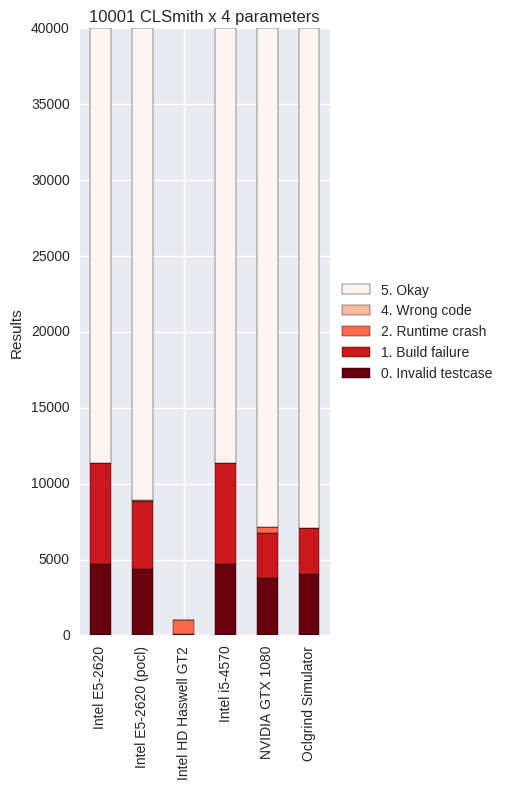

In [17]:
plot_outcomes(CLSmithResult, "CLSmith", dictname=classifications, key='Classification')

### CLgen w. cl_launcher

In [18]:
outcomes["CLgen w. cl_launcher"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,CL_INVALID_KERNEL_ARGS,1008,56.502242
1,NVIDIA GTX 1080,Error setting kernel argument,238,13.340807
2,NVIDIA GTX 1080,z_Okay,228,12.780269
3,NVIDIA GTX 1080,Error building program: -42,198,11.098655
4,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,72,4.035874
5,NVIDIA GTX 1080,Error enqueueing kernel,20,1.121076
6,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,20,1.121076
7,Intel E5-2620,Error enqueueing kernel,1028,57.623318
8,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,272,15.246637
9,Intel E5-2620,Error setting kernel argument,236,13.228700


In [19]:
summarize('CLgen w. cl_launcher')

Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 528 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   37c7164..9753c96  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,1264,294,0,0,0
2,POCL,Intel E5-2620 (pocl),0.14,0,0,1784,0,0
3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,1260,288,8,0,0
4,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,1264,294,0,0,0
5,NVIDIA CUDA,NVIDIA GTX 1080,375.39,1464,92,0,0,0


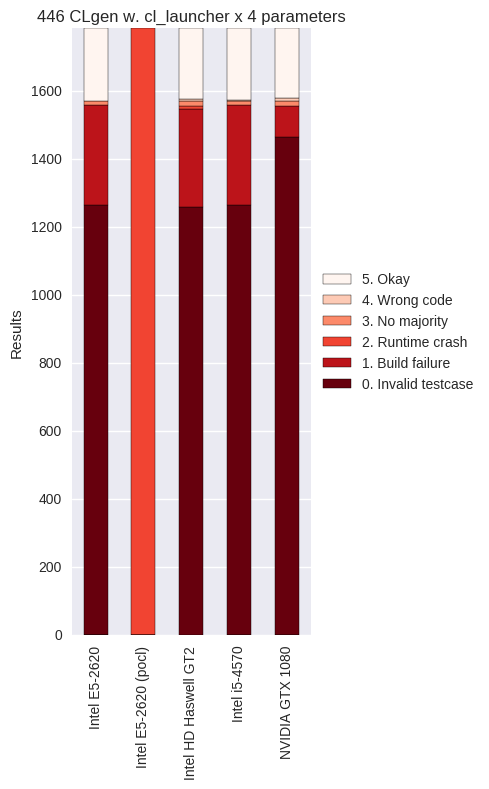

In [20]:
plot_outcomes(cl_launcherCLgenResult, "CLgen w. cl_launcher", dictname=classifications, key='Classification')

### CLSmith w. cldrive

In [21]:
outcomes["CLSmith w. cldrive"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,32899,82.239276
1,NVIDIA GTX 1080,Preprocessing Failed,5311,13.276172
2,NVIDIA GTX 1080,z_Okay,1655,4.137086
3,NVIDIA GTX 1080,No OpenCL kernel,64,0.159984
4,NVIDIA GTX 1080,cldrive Error,56,0.139986
5,NVIDIA GTX 1080,Timeout,12,0.029997
6,NVIDIA GTX 1080,clWaitForEvents(),3,0.007499
7,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.007499
8,NVIDIA GTX 1080,Segmentation Fault,1,0.002500
9,Intel E5-2620,Unsupported Program,37940,94.840516


In [22]:
summarize('CLSmith w. cldrive')

Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 419 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   9753c96..e033d7c  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,38094,6,92,0,0
2,POCL,Intel E5-2620 (pocl),0.14,40004,0,0,0,0
3,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,40004,0,0,0,0
4,NVIDIA CUDA,NVIDIA GTX 1080,375.39,38342,1,6,0,0
5,Oclgrind,Oclgrind Simulator,16.10,39973,0,0,0,0


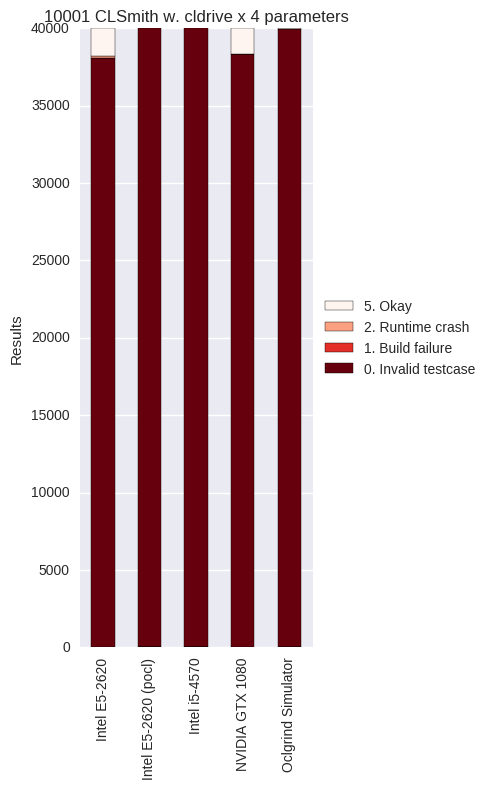

In [23]:
plot_outcomes(cldriveCLSmithResult, "CLSmith w. cldrive", dictname=classifications, key='Classification')

### GitHub

In [24]:
outcomes["GitHub"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,17594,37.081375
1,NVIDIA GTX 1080,z_Okay,10019,21.116193
2,NVIDIA GTX 1080,cldrive Error,6816,14.365503
3,NVIDIA GTX 1080,Multiple OpenCL kernels,5330,11.233587
4,NVIDIA GTX 1080,No OpenCL kernel,5018,10.576011
5,NVIDIA GTX 1080,clWaitForEvents(),1502,3.165637
6,NVIDIA GTX 1080,Preprocessing Failed,726,1.530128
7,NVIDIA GTX 1080,INVALID_WORK_GROUP_SIZE,369,0.777710
8,NVIDIA GTX 1080,Timeout,68,0.143318
9,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.006323


In [25]:
summarize('GitHub')

Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 428 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   e033d7c..b2c6122  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,27352,1401,32,0,0
2,POCL,Intel E5-2620 (pocl),0.14,25421,1551,1440,0,0
3,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,25561,1363,31,0,0
4,NVIDIA CUDA,NVIDIA GTX 1080,375.39,35921,2,1505,0,0
5,Oclgrind,Oclgrind Simulator,16.10,36952,0,0,0,0


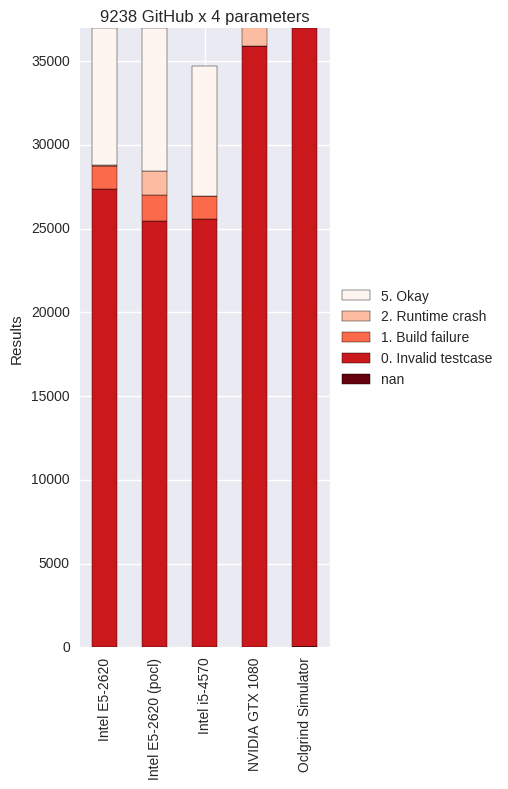

In [26]:
plot_outcomes(GitHubResult, "GitHub", dictname=classifications, key='Classification')

### CLgen

In [27]:
outcomes["CLgen"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,5247,92.768741
1,NVIDIA GTX 1080,cldrive Error,278,4.915134
2,NVIDIA GTX 1080,clWaitForEvents(),58,1.025460
3,NVIDIA GTX 1080,Unsupported Program,56,0.990099
4,NVIDIA GTX 1080,INVALID_WORK_GROUP_SIZE,16,0.282885
5,NVIDIA GTX 1080,Segmentation Fault,1,0.017680
6,Intel E5-2620,z_Okay,5218,92.256011
7,Intel E5-2620,cldrive Error,282,4.985856
8,Intel E5-2620,Segmentation Fault,84,1.485149
9,Intel E5-2620,Unsupported Program,56,0.990099


In [28]:
summarize('CLgen')

Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 485 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   b2c6122..990d2c7  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,354,84,0,0,0
2,POCL,Intel E5-2620 (pocl),0.14,159,62,197,0,0
3,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,408,158,0,0,0
4,NVIDIA CUDA,NVIDIA GTX 1080,375.39,350,1,58,0,0
5,Oclgrind,Oclgrind Simulator,16.10,2,0,0,0,0


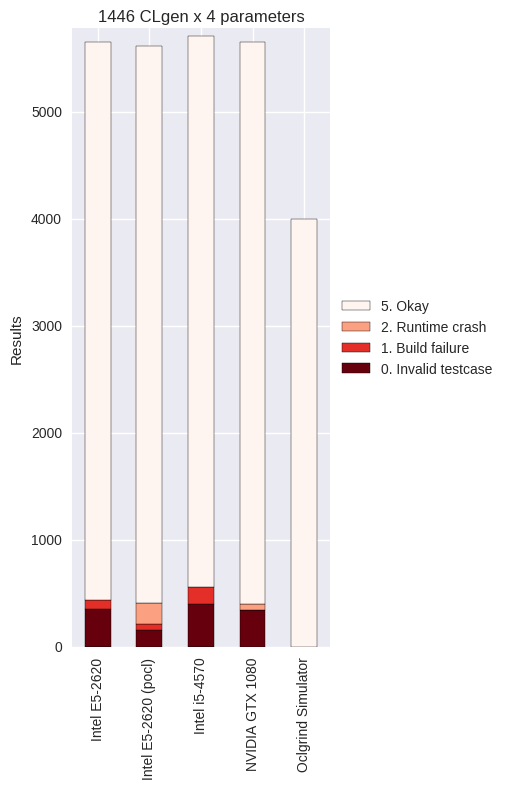

In [29]:
plot_outcomes(CLgenResult, "CLgen", dictname=classifications, key='Classification')